0.5m/s, 0.04s, sigma=0.02m
1m/s, 0.04s, sigma=0.04m
2m/s, 0.04s, sigma=0.08m


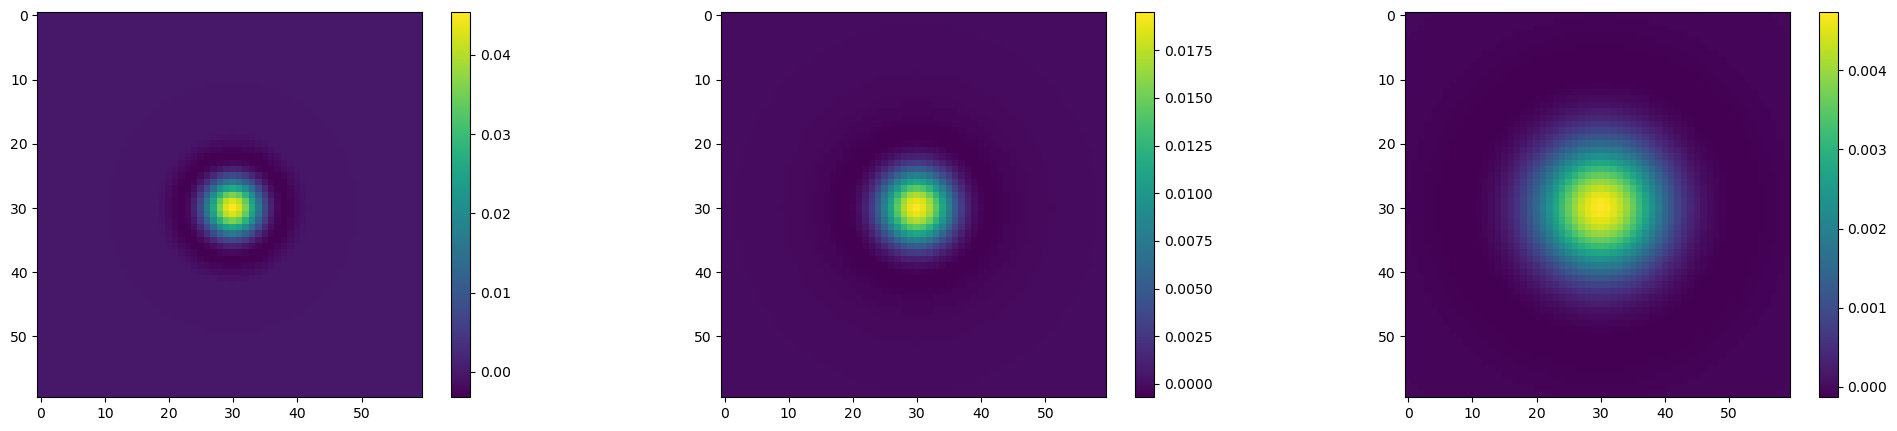

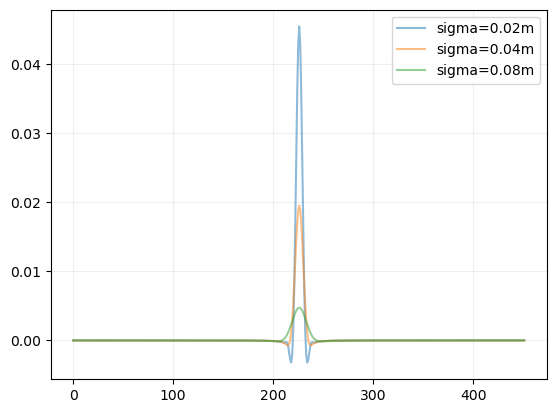

In [3]:
import time
import numpy as np
from skimage.filters import gaussian
import matplotlib.pyplot as plt
import os

np.seterr(divide='ignore')

# --- апертурный фильтр
def processApertureFilter(nx, fx, fy, delta): 
    res = np.abs(np.sinc(delta*fx)*np.sinc(delta*fy))**2
    res[np.isnan(res)] = 0
    return res
    
# --- модуль |f|^11/3 
def processF_113(nx, fx, fy):
    res = pow(np.sqrt(fx**2+fy**2), -11./3.)
    res[np.isnan(res)] = 0
    return res

# --- фильтр Френеля
def processFresnelFilter(nx, fx, fy, z, lambda_): 
    res = pow(np.sin(np.pi*z*lambda_*(fx**2+fy**2)), 2) / pow(lambda_, 2)
    res[np.isnan(res)] = 0
    return res

# --- монохроматические гаммы со скоростями 0 м/с
def processGammaMono(z, lambda_, Gv=None, t=None, cjk=None, const2=None, nx=None, fx=None, fy=None, Aff113=None):
    Fresnel_filter = processFresnelFilter(nx, fx, fy, z, lambda_)   
    
    with np.errstate(invalid='ignore'):
        res = Aff113 * Fresnel_filter
    
    res[np.isnan(res)] = 0
    
    res = np.fft.fftshift(np.fft.irfft2(np.fft.fftshift(res), s=res.shape, norm='backward'))
    
    res = res * const2
    delta = 2.5/226
    res = gaussian(res, sigma=Gv*t/(delta))
    return res

def processGamma(lambda_, Cn2=None, cjk=None, Gv=None, D=None, num_of_layers=None, heights_of_layers=None, latency=None, 
                 sec_per_frame=None, data_dir=None):  
    # частотный движ, фильтры и прочее, чтобы в цикле не считать каждый раз
    nx=cjk.shape[0]
    f_scale = 1/(2*D) # шаг по частоте, [м^-1]
    delta = D/(cjk.shape[0]//2) # шаг субапертуры, период дискретизации (то, насколько одно значение отстает от следующего) [м]
    fx, fy = f_scale * np.asarray(np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx)))
    f_11_3 = processF_113(nx, fx, fy)
    A_f = processApertureFilter(nx, fx, fy, delta) 
    Aff113 = f_11_3 * A_f
    
    # константы для рассчета гамм, чтобы в цикле не считать каждый раз
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2)
    const2 = const * Cn2 * pow(f_scale*nx, 2)
    
    # выкладки для 3м массива гамм
    gammas1 = []

    for i in range(len(Gv)):
        for j in range(len(latency)):
            t = latency[j]*sec_per_frame
            print(f'{Gv[i]}m/s, {t}s, sigma={Gv[i]*t}m')
            tmp = processGammaMono(heights_of_layers, lambda_, Gv=Gv[i], t=t, cjk=cjk, const2=const2, nx=nx, fx=fx, fy=fy, Aff113=Aff113)
            tmp = gaussian(tmp, sigma=1)
            gammas1.append(tmp)
            
    return gammas1


data_dir = 'D:/astro/domecam/crosscorr'
cjk = np.load(f'{data_dir}/20210130l_m2km_cjk.npy')
lambda_=500*1e-9
num_of_layers=1
heights_of_layers = 10000
sec_per_frame=0.01
latency=[4]
Gv=[0.5, 1, 2]
#нужно перевести метров в пиксели

gammas = processGamma(lambda_, Cn2=1e-13, cjk=cjk, Gv=Gv, D=2.5, num_of_layers=num_of_layers, 
                      heights_of_layers=heights_of_layers, latency=latency, sec_per_frame=sec_per_frame, data_dir=data_dir)
gammas = np.array(gammas)



k=30
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
fig.colorbar(ax.imshow(gammas[0][226-k:226+k, 226-k:226+k]), ax=ax)
fig.colorbar(ax2.imshow(gammas[1][226-k:226+k, 226-k:226+k]), ax=ax2)
fig.colorbar(ax3.imshow(gammas[2][226-k:226+k, 226-k:226+k]), ax=ax3)

plt.figure()
plt.plot(gammas[0][226, :], alpha=0.5, label='sigma=0.02m')
plt.plot(gammas[1][226, :], alpha=0.5, label='sigma=0.04m')
plt.plot(gammas[2][226, :], alpha=0.5, label='sigma=0.08m')
plt.legend()
plt.grid(alpha=0.2)